In [1]:
##The dataset is loaded to your GDrive so need to be mounted
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Satellite Project/')

Mounted at /content/drive


In [1]:
START_IDX = 0
saved_model_name = 'deeplab_full.pt'

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torchvision import models

import os
import random
import gc
from tqdm import tqdm
import torch.nn.functional as F
from utils import *
from datasets.dataset import ChangeDetectionDataset

In [2]:
# set seed to 0
torch.manual_seed(0)
x1 = torch.randn(3,3)
x2 = torch.randn(3,3)

# concatenate along the first axis
y1 = torch.cat((x1, x2), 0)
print(y1)
# concatenate along the second axis
y2 = torch.cat((x1, x2), 1)
print(y2)

tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986],
        [ 0.4033,  0.8380, -0.7193],
        [-0.4033, -0.5966,  0.1820],
        [-0.8567,  1.1006, -1.0712],
        [ 0.1227, -0.5663,  0.3731]])
tensor([[ 1.5410, -0.2934, -2.1788, -0.4033, -0.5966,  0.1820],
        [ 0.5684, -1.0845, -1.3986, -0.8567,  1.1006, -1.0712],
        [ 0.4033,  0.8380, -0.7193,  0.1227, -0.5663,  0.3731]])


## Read Data


In [3]:
training_path = './trainval/'

In [4]:
after_images = read_data(training_path, 'after',START_IDX)
before_images = read_data(training_path,'before',START_IDX)
labels = read_data(training_path,'label',START_IDX)

Time taken to read  after  images: 42.22 seconds
Time taken to read  before  images: 17.45 seconds
Time taken to read  label  images: 2.95 seconds


In [5]:
# diff_images = read_data(training_path,'diff',START_IDX)
# labels = read_data(training_path,'label',START_IDX)

In [6]:
print(len(before_images))
print(len(after_images))
print(len(labels))

4868
4868
4868


In [7]:
labels[0].max()

255

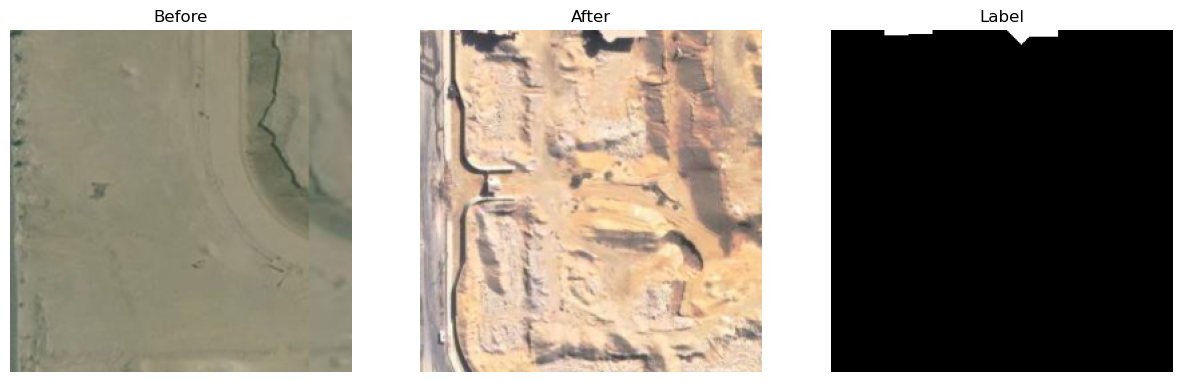

In [8]:
index = 0
display_images([before_images[index], after_images[index]], labels[index])

## Create Datasets


In [9]:
batch_size = 16
train_val_ratio = 0.8

In [10]:
# Define transformations
transform_rgb = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_label = transforms.Compose([
    transforms.ToTensor(),
])

# Assuming you have instantiated your dataset like this
dataset = ChangeDetectionDataset(before_images, after_images, labels, transform_rgb, transform_label)

# Define the indices for train and validation sets
train_size = int(train_val_ratio * len(dataset))
val_size = len(dataset) - train_size

torch.manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders for train and validation sets
train_loader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle = True)

In [11]:
# del before_images
# del after_images
# del labels
# gc.collect()

In [12]:
print("Percentage of pure black masks in training set:", count_pure_black_masks(train_loader))
print("Percentage of pure black masks in validation set:", count_pure_black_masks(val_loader))

Percentage of pure black masks in training set: 66.39276910435498
Percentage of pure black masks in validation set: 66.11909650924025


In [13]:
print("Train size:", len(train_loader) * batch_size)
print("Validation size:", len(val_loader) * batch_size)

Train size: 4880
Validation size: 976


In [14]:
# before_images, after_images, label = train_dataset[0]
# print(before_images.shape)
# print(after_images.shape)
# print(label.shape)

## Model

DeepLab is a series of convolutional neural network architectures designed for semantic image segmentation. Here, I'll provide an overview of the DeepLabv3+ architecture, which is one of the latest versions and has shown impressive performance in various segmentation tasks.

### DeepLabv3+ Architecture Overview:

1. **Backbone Network**: DeepLabv3+ typically uses a powerful convolutional neural network as its backbone for feature extraction. Popular choices include ResNet, MobileNetv2, or Xception.

2. **ASPP Module (Atrous Spatial Pyramid Pooling)**: This module captures multi-scale information by applying atrous convolutions at multiple dilation rates. It helps the network to gather context from a broader area while retaining spatial resolution.

3. **Decoder Module**: DeepLabv3+ employs a decoder module to refine the segmentation results. It typically consists of upsampling layers and skip connections to recover spatial information lost during downsampling.

4. **Final Classification Layer**: The final classification layer generates pixel-wise predictions for each class in the segmentation task.

### Implementation using PyTorch:

Below is a simplified example of how to implement DeepLabv3+ using PyTorch. This code assumes you have PyTorch installed and have basic knowledge of convolutional neural networks.
In this implementation, the `ASPP` module captures multi-scale features, and the `DeepLabV3Plus` class combines the backbone network, ASPP module, and decoder to produce pixel-wise predictions. Adjust the number of output classes according to your segmentation task. This code is a simplified version and may need further adjustments depending on your specific requirements and dataset.

In [36]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels=256, rates=[6, 12, 18]):
        super(ASPP, self).__init__()
        self.conv1x1_1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv1x1_2 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv1x1_3 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv1x1_4 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv3x3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.atrous_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=rates[0], dilation=rates[0])
        self.atrous_conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=rates[1], dilation=rates[1])
        self.atrous_conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=rates[2], dilation=rates[2])
        
    def forward(self, x):
        x1 = self.conv1x1_1(x)
        x2 = self.atrous_conv1(x)
        x3 = self.atrous_conv2(x)
        x4 = self.atrous_conv3(x)
        
        x1 = self.relu(self.bn(self.conv3x3(x1)))
        x2 = self.relu(self.bn(self.conv3x3(x2)))
        x3 = self.relu(self.bn(self.conv3x3(x3)))
        x4 = self.relu(self.bn(self.conv3x3(x4)))
        
        return torch.cat([x1, x2, x3, x4], dim=1)

class DeepLabV3Plus(nn.Module):
    # assume we have 2 classes: change and no change
    def __init__(self, num_classes=2):
        super(DeepLabV3Plus, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.aspp = ASPP(in_channels=2048)
        
        self.conv1x1 = nn.Conv2d(2048, 256, kernel_size=1)
        self.conv3x3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(256, num_classes, kernel_size=1)
        
    def forward(self, old_image, new_image):
        # Process old image
        x_old = self.backbone.conv1(old_image)
        x_old = self.backbone.bn1(x_old)
        x_old = self.backbone.relu(x_old)
        x_old = self.backbone.maxpool(x_old)
        x_old = self.backbone.layer1(x_old)
        x_old = self.backbone.layer2(x_old)
        x_old = self.backbone.layer3(x_old)
        x_old = self.backbone.layer4(x_old)
        
        # Process new image
        x_new = self.backbone.conv1(new_image)
        x_new = self.backbone.bn1(x_new)
        x_new = self.backbone.relu(x_new)
        x_new = self.backbone.maxpool(x_new)
        x_new = self.backbone.layer1(x_new)
        x_new = self.backbone.layer2(x_new)
        x_new = self.backbone.layer3(x_new)
        x_new = self.backbone.layer4(x_new)
        # print("Xnew size", x_new.size())
        # print("Xold size", x_old.size())
        # Atrous Spatial Pyramid Pooling
        x_old = self.aspp(x_old)
        x_new = self.aspp(x_new)
        # print("Xnew size", x_new.size())
        # print("Xold size", x_old.size())
        # Combine features
        x = torch.cat([x_old, x_new], dim=1)
        # print("X size", x.size())
        # Further convolution
        x = self.conv1x1(x)
        # print(x.size())
        x = self.conv3x3(x)
        # print(x.size())
        
        # Final classification
        x = self.final_conv(x)
        # print(x.size())
        
        # Upsample to original size
        x = F.interpolate(x, size=(old_image.size(2), old_image.size(3)), mode='bilinear', align_corners=False)
        
        return x.squeeze()

In [37]:
# Create an instance of the model, label_nbr
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepLabV3Plus().to(device)
criterion = nn.BCEWithLogitsLoss()
print(device)

cuda


In [38]:
learning_rate = 0.001
threshold = 0.3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [39]:
# from torchsummary import summary
# summary(model,input_size=[(3,256,256),(3,256,256)])

## Train Model


In [40]:
def train_model(model, device, train_loader, criterion, optimizer, scheduler, num_epochs=50, save_dir="saved_models"):
    n_steps = len(train_loader)
    jaccard_loss = 0.0
    best_jaccard_score = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # total_iou = 0.0

        predicted_masks_list = []
        true_masks_list = []
        for data in tqdm(train_loader):
            before_image, after_image, true_masks = data
            before_image = before_image.to(device)
            after_image = after_image.to(device)
            true_masks = true_masks.to(device)

            optimizer.zero_grad()
            # masks_pred = model(before_image, after_image)  # Pass both before and after images to the model
            masks_pred = model.forward(before_image, after_image)  # Pass both before and after images to the model
            out = torch.zeros(masks_pred.shape[0],1, masks_pred.shape[2], masks_pred.shape[3]).to(device)
            for k in range(masks_pred.shape[0]):
                for i in range(masks_pred.shape[2]):
                    for j in range(masks_pred.shape[3]):
                        soft_out = torch.nn.functional.softmax(torch.tensor([masks_pred[k][0][i, j], masks_pred[k][1][i, j]]), dim=0)
                        out[k,0, i, j] = torch.argmax(soft_out) * 255

            loss = criterion(out, true_masks)
            # loss = criterion(masks_pred, true_masks)
            loss += 0.6 * jaccard_loss
            loss.requires_grad = True
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            pred_masks = (masks_pred > threshold).float()

            for i, pred_mask in enumerate(pred_masks):
                pred_mask = pred_mask.squeeze().cpu().numpy()
                predicted_masks_list.append(pred_mask)

                true_mask = true_masks[i].squeeze().cpu().numpy()
                true_masks_list.append(true_mask)

            # Clearing unnecessary variables from GPU memory
            del before_image, true_masks, masks_pred, loss

        epoch_iou, overall_accuracy = evaluate(predicted_masks_list, true_masks_list)
        epoch_loss = running_loss / n_steps
        jaccard_loss = 1 - epoch_iou

        print(f'Epoch [{epoch + 1}/{num_epochs}] Finished, Loss: {epoch_loss:.5f}, Jaccard Index: {epoch_iou*100:.3f}%, Accuracy: {overall_accuracy*100:.3f}%, Learning Rate: {optimizer.param_groups[0]["lr"]}')
        # Step the scheduler based on the validation IoU
        scheduler.step()

        model_path = os.path.join(save_dir, saved_model_name)
        if epoch_iou > best_jaccard_score:
            best_jaccard_score = epoch_iou
            print(f'Best Jaccard Index: {best_jaccard_score*100:.5f}%')
            torch.save(model.state_dict(), model_path)

        running_loss = 0.0

In [41]:
# Train the model
train_model(model, device, train_loader, criterion, optimizer, scheduler, num_epochs=10, save_dir= "saved_models")

  0%|          | 0/305 [00:00<?, ?it/s]

Xnew size torch.Size([16, 2048, 8, 8])
Xold size torch.Size([16, 2048, 8, 8])
Xnew size torch.Size([16, 1024, 8, 8])
Xold size torch.Size([16, 1024, 8, 8])
X size torch.Size([16, 2048, 8, 8])
torch.Size([16, 256, 8, 8])
torch.Size([16, 256, 8, 8])
torch.Size([16, 2, 8, 8])


  0%|          | 0/305 [01:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# # Load the latest saved model
model = load_model(model, save_dir="saved_models", model_name=saved_model_name)

In [ ]:
class BinaryConfusionMatrix():
    def __init__(self):
        super(BinaryConfusionMatrix, self).__init__()
        self.tp = 0
        self.fp = 0
        self.tn = 0
        self.fn = 0

    def update(self, pred: torch.Tensor, target: torch.Tensor) -> None:
        self.tp += ((target == pred) & (target == 1)).sum().item()
        self.fp += ((target != pred) & (target == 0)).sum().item()
        self.tn += ((target == pred) & (target == 0)).sum().item()
        self.fn += ((target != pred) & (target == 1)).sum().item()

    def compute(self) -> torch.Tensor:
        return torch.tensor([self.tp, self.fp, self.tn, self.fn]).view(2, 2)

    def reset(self) -> None:
        self.tp = 0
        self.fp = 0
        self.tn = 0
        self.fn = 0

    def get_jaccard(self) -> float:
        union = self.tp + self.fp + self.fn
        return self.tp / union if union > 0 else 1.0


In [ ]:
confusion_matrix = BinaryConfusionMatrix()

In [ ]:
def validate_new(model, test_loader, device, threshold = 0.3):
    before_images_list = []
    after_images_list = []
    predicted_masks_list = []
    true_masks_list = []

    with torch.no_grad():
        for data in tqdm(test_loader):
            before_image, after_image, label = data

            before_image = before_image.to(device)
            after_image = after_image.to(device)
            label = label.to(device)

            outputs = model(before_image, after_image)

            # Apply threshold to model outputs
            pred_masks = (outputs > threshold).float()
            confusion_matrix.update(pred_masks,label)
            for i, pred_mask in enumerate(pred_masks):
                before_images_list.append(before_image[i].cpu())
                after_images_list.append(after_image[i].cpu())

                # Save binary predicted mask
                pred_mask = pred_mask.squeeze().cpu().numpy()
                predicted_masks_list.append(pred_mask)

                true_mask = label[i].squeeze().cpu().numpy()
                true_masks_list.append(true_mask)

    return before_images_list, after_images_list, predicted_masks_list, true_masks_list


## Validate Model


In [ ]:
before_images_list, after_images_list, predicted_masks_list, true_masks_list = validate_new(model, val_loader, device, threshold)

100%|██████████| 61/61 [00:31<00:00,  1.96it/s]


In [ ]:
confusion_matrix.compute()

tensor([[ 3157440,   663583],
        [58936728,  1074313]])

In [ ]:
confusion_matrix.get_jaccard()

0.6449894348416534

In [ ]:
jaccard, overall_accuracy = evaluate(predicted_masks_list, true_masks_list)
print("Validation")
print(f"Mean Jaccard Index :{jaccard*100:.5f}%")
# print(f"Overall Accuracy : {overall_accuracy*100:.5f}%")

Validation
Mean Jaccard Index :80.30303%


In [ ]:
display_predicted_images(before_images_list, after_images_list, predicted_masks_list, true_masks_list)

In [ ]:
# save_predictions(predicted_masks_list, predicted_images_dir)